In [22]:
import cv2
from matplotlib import pyplot
import numpy
from scipy.fftpack import dct
from scipy.fftpack import idct
import struct
import zlib

# Zadanie 1

In [23]:
#
# PPM file header
#
ppm_ascii_header = 'P3\n2 2\n255\n'  # TODO: implement
ppm_binary_header = 'P6\n2 2\n255\n'  # TODO: implement

#
# Image data
#
image = numpy.array([128, 0, 255, 255, 255, 255, 255, 0, 0, 0, 255, 0], dtype=numpy.uint8)  # TODO: implement

#
# Save the PPM image as an ASCII file
#
with open('lab4-ascii.ppm', 'w') as fh:
    fh.write(ppm_ascii_header)
    image.tofile(fh, sep=' ')
    fh.write('\n')

#
# Save the PPM image as a binary file
#
with open('lab4-binary.ppm', 'wb') as fh:
    fh.write(bytearray(ppm_binary_header, 'ascii'))
    image.tofile(fh)

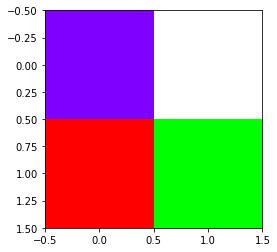

In [24]:
#
# Display image
#
image_from_file = cv2.imread('lab4-ascii.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

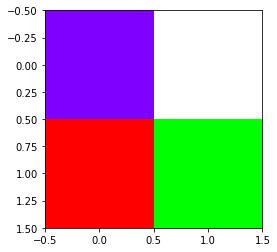

In [25]:
#
# Display image
#
image_from_file = cv2.imread('lab4-binary.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Zadanie 2

In [49]:
width, height = 364, 20
different_colors = 51
step = 255 // different_colors

ppm_ascii_header = f'P3\n{width} {height}\n255\n'
ppm_binary_header = f'P6\n{width} {height}\n255\n'

R = 0  # red
G = 1  # green
B = 2  # blue
rainbow_list = []
current_color = [0, 0, 0]  # begin with black


def change_colors(_current_color, channel, _step):
    for i in range(different_colors):
        rainbow_list.append(_current_color[0])
        rainbow_list.append(_current_color[1])
        rainbow_list.append(_current_color[2])
        _current_color[channel] += _step
    rainbow_list.append(_current_color[0])
    rainbow_list.append(_current_color[1])
    rainbow_list.append(_current_color[2])


change_colors(current_color, B, step)  # black -> blue
change_colors(current_color, G, step)  # blue -> light blue
change_colors(current_color, B, -step)  # light blue -> green
change_colors(current_color, R, step)  # green -> yellow
change_colors(current_color, G, -step)  # yellow -> red
change_colors(current_color, B, step)  # red -> purple
change_colors(current_color, G, step)  # purple -> white

rainbow_list = rainbow_list * height

rainbow_image = numpy.array(rainbow_list, dtype=numpy.uint8)

#
# Save the PPM image as a binary file
#
with open('lab4-rainbow.ppm', 'wb') as fh:
    fh.write(bytearray(ppm_binary_header, 'ascii'))
    rainbow_image.tofile(fh)
print("Done")

Done


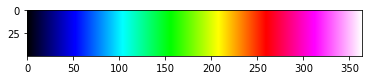

In [50]:
#
# Display image
#
image_from_file = cv2.imread('lab4-rainbow.ppm')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Zadanie 3


In [15]:
#
# Data image
#
image = rainbow_image.reshape((height, width, 3))
#
# Construct signature
#
png_file_signature = b'\x89PNG\r\n\x1a\n'

#
# Construct header
#
header_id = b'IHDR'
header_content = struct.pack('!I', width) + \
                 struct.pack('!I', height) + \
                 struct.pack('!B', 8) + \
                 struct.pack('!B', 2) + \
                 struct.pack('!B', 0) + \
                 struct.pack('!B', 0) + \
                 struct.pack('!B', 0)
header_size = struct.pack('!I', len(header_content))
header_crc = struct.pack('!I', zlib.crc32(header_id + header_content))
png_file_header = header_size + header_id + header_content + header_crc

#
# Construct data
#
data_id = b'IDAT'
data_content = zlib.compress(b''.join([b'\x00' + bytes(row) for row in image]))
data_size = struct.pack('!I', len(data_content))
data_crc = struct.pack('!I', zlib.crc32(data_id + data_content))
png_file_data = data_size + data_id + data_content + data_crc

#
# Construct end
#
end_id = b'IEND'
end_content = b''
end_size = struct.pack('!I', len(end_content))
end_crc = struct.pack('!I', zlib.crc32(end_id + end_content))
png_file_end = end_size + end_id + end_content + end_crc

#
# Save the PNG image as a binary file
#
with open('lab4.png', 'wb') as fh:
    fh.write(png_file_signature)
    fh.write(png_file_header)
    fh.write(png_file_data)
    fh.write(png_file_end)

print("Done")

(20, 364, 3)
Done


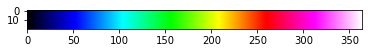

In [16]:
#
# Display image
#
image_from_file = cv2.imread('lab4.png')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Funkcje pomocnicze do zadań 4 i 5

In [ ]:
#
# 2d Discrete Cosinus Transform
#
def dct2(array):
    return dct(dct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


def idct2(array):
    return idct(idct(array, axis=0, norm='ortho'), axis=1, norm='ortho')


#
# Calculate quantisation matrices
#
# Based on: https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html
#           #step-3-and-4-discrete-cosinus-transform-and-quantisation
#
_QY = numpy.array([[16, 11, 10, 16, 24, 40, 51, 61],
                   [12, 12, 14, 19, 26, 48, 60, 55],
                   [14, 13, 16, 24, 40, 57, 69, 56],
                   [14, 17, 22, 29, 51, 87, 80, 62],
                   [18, 22, 37, 56, 68, 109, 103, 77],
                   [24, 35, 55, 64, 81, 104, 113, 92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])

_QC = numpy.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]])


def _scale(QF):
    if QF < 50 and QF >= 1:
        scale = numpy.floor(5000 / QF)
    elif QF < 100:
        scale = 200 - 2 * QF
    else:
        raise ValueError('Quality Factor must be in the range [1..99]')

    scale = scale / 100.0
    return scale


def QY(QF=85):
    return _QY * _scale(QF)


def QC(QF=85):
    return _QC * _scale(QF)

# Zadania 4 i 5

In [ ]:
#
# 0. Image data
#
# TODO: implement (zad. 4)
image = rainbow_image.reshape((height, width, 3))
#
# 1. Convert RGB to YCbCr
#
# TODO: implement (zad. 4)
image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

#
# 2. Downsampling on Cb and Cr channels
#
# TODO: implement (zad. 4)


#
# 3. Produce 8x8 blocks
#
# TODO: implement (zad. 4)

#
# 4. Calculate DCT on each block
#
# TODO: implement (zad. 5)

#
# 5. Divide each block by quantisation matrix
#
# TODO: implement (zad. 5)

#
# 6. Round values in each block to integers
#
# TODO: implement (zad. 5)

#
# 7. Zig Zag
#
# TODO: implement (zad. 4)

#
# 8. Flatten, concatenate, compress and calculate the size -- how many bytes?
#
# TODO: implement (zad. 4)

#
# 7'. Undo Zig Zag
#
# We can skip it in this exercise! We did Zig Zag only for analysis in step 8.
# You can continue with result from step 6. instead of implementing undo here.
#

#
# 6'. Nothing to do here   ¯\_(ツ)_/¯
#
# No conversion is really needed here, just proceed to the next step.
#

#
# 5'. Reverse division by quantisation matrix -- multiply
#
# TODO: implement (zad. 5)

#
# 4'. Reverse DCT
#
# TODO: implement (zad. 5)

#
# 3'. Combine 8x8 blocks to original image
#
# TODO: implement (zad. 4)

#
# 2'. Upsampling on Cb and Cr channels
#
# TODO: implement (zad. 4)

#
# 1'. Convert YCbCr to RGB
#
# TODO: implement (zad. 4)

#
# 0'. Save the decoded image -- as PPM or PNG
#
# TODO: implement (zad. 4)

In [ ]:
#
# Display image
#
image_from_file = cv2.imread('lab4-po-kompresji-i-dekompresji-jpeg.png')
pyplot.imshow(cv2.cvtColor(image_from_file, cv2.COLOR_BGR2RGB))

# Obserwacje z zadań 4 i 5